In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import env_basketball

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn

In [4]:
import agent as agent
# import agent_flat as agent

In [5]:
env = env_basketball.BasketballEnv(config={'n_offensive_players': 1, 'n_defensive_players': 0})

In [6]:
net = agent.OffenseNet(env)
print('n_params: ', np.sum([p.numel() for p in net.parameters()]))

n_params:  9857


In [7]:
state = env.reset()

for t in range(50):
    # action = env_basketball.get_random_action(env, env.state)
    action = net.calc_action(state)
    state, reward, done, info = env.step(action)
    


In [58]:
ani, vid = env.render_episode(mode='vid', tqdm=tqdm)
vid

  0%|          | 0/51 [00:00<?, ?it/s]

0.6876031756401062


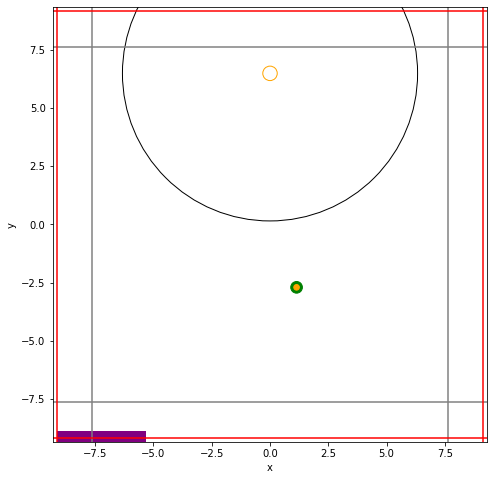

In [63]:
env.render()
print(env.evaluate_ppp())

In [60]:
net = agent.OffenseNet(env)
net.calc_action(state)

{'shooting': False,
 'accs': array([[0.37622952, 0.5492088 ]], dtype=float32),
 'passing': False,
 'pass_receiver': None}

In [30]:
state = env.reset()

In [36]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [8]:
def calc_fitness(v, net=net):
    state = env.reset()
    nn.utils.vector_to_parameters(v, net.parameters())
    for t in range(50):
        # action = env_basketball.get_random_action(env, env.state)
        action = net.calc_action(state)
        state, reward, done, info = env.step(action)
    return env.evaluate_ppp()

In [9]:
net = agent.OffenseNet(env)
v = nn.utils.parameters_to_vector(net.parameters())
v = torch.randn_like(v)/10.
print(v.shape)

torch.Size([9857])


In [10]:
[calc_fitness(v) for _ in range(10)]

[0.126835435628891,
 0.29520100355148315,
 0.15867826342582703,
 0.24277710914611816,
 0.09040476381778717,
 1.2941573858261108,
 0.1311693638563156,
 1.2291127443313599,
 0.7396675944328308,
 1.0770703554153442]

In [15]:
        
sigma = 1e-1
lr=1e-4

def calc_grad(v, n_pop=5):
    eps = torch.randn(n_pop, *v.shape)
    vs = v+eps*sigma
    Fs = torch.tensor([calc_fitness(vi) for vi in vs])
    Fns = (Fs-Fs.mean())/Fs.std()
    
    grad = 1./(n_pop*sigma)*(Fs[:, None]*eps).sum(dim=0)
    return Fs, grad

def run_es_adam(v, n_gen=100, n_pop=5):
    v = v.clone()
    opt = torch.optim.Adam([v], lr=1e-2)
    Fss = []
    pbar = tqdm(range(n_gen))
    for i in pbar:
        Fs, grad = calc_grad(v.detach().clone(), n_pop=n_pop)
        # print(Fs.min().item(), Fs.mean().item(), Fs.max().item())
        v.grad = -grad
        opt.step()
        Fss.append(Fs)
        # print(Fs.mean().item(), Fs.std().item())
        pbar.set_postfix({'Fs': Fs.mean().item(), 'Fstd': Fs.std().item()})
    return torch.stack(Fss)
    
    

In [17]:
net = agent.OffenseNet(env)
v = nn.utils.parameters_to_vector(net.parameters())
v = torch.randn_like(v)/1e6
print(v.shape)
fits = run_es_adam(v, n_gen=300, n_pop=20)

torch.Size([9857])


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [85]:
[calc_fitness(v) for _ in range(10)]

[1.1462304592132568,
 0.05719783157110214,
 1.2294721603393555,
 1.5930061340332031,
 1.2407422065734863,
 0.6374799013137817,
 0.3588082492351532,
 0.5519528985023499,
 0.7512339353561401,
 0.9444206953048706]

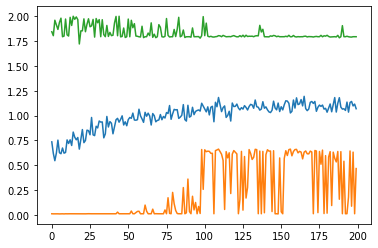

In [86]:
plt.plot(fits.mean(dim=-1))
plt.plot(fits.min(dim=-1).values)
plt.plot(fits.max(dim=-1).values)

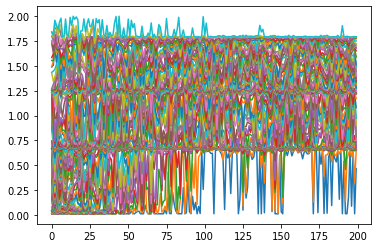

In [87]:
plt.plot(fits.sort(dim=-1).values);

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_sins = 100
        self.seq = nn.Sequential(
            nn.Linear(self.n_sins, 50),
            nn.Tanh(),
            nn.Linear(50, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        if x.ndim==1:
            x = x[None, :]
        x = x/7.5*np.pi/2.
        x = x*torch.arange(-self.n_sins//2, self.n_sins//2)
        # x = x*torch.arange(0, self.n_sins)
        x = x.sin()
        x = self.seq(x)
        return x

net = Net()

In [43]:
def calc_fitness(v, net=net):
    nn.utils.vector_to_parameters(v, net.parameters())
    pos = torch.linspace(-8, -7)[:, None]
    vel = torch.zeros_like(pos)
    acc = torch.zeros_like(pos)
    for t in range(20):
        dt = .1
        action = net(pos).detach().clone()
        # jerk = action
        # jerk = torch.clip(jerk, -1.3, 1.3)
        # acc += jerk*dt
        acc = action
        # acc = torch.clip(acc, -2.95, 2.95)
        vel += acc*dt
        # vel = action
        vel = torch.clip(vel, -6.7, 6.7)
        pos += vel*dt
        pos = torch.clip(pos, -12., 12.)
        # pos = action
        
    fitness =  -(pos-7.5).pow(2)
    return fitness.mean().item()


sigma = 1e-1
lr = 1e-4

def calc_grad(v, n_pop=5):
    eps = torch.randn(n_pop, *v.shape)
    vs = v+eps*sigma
    Fs = torch.tensor([calc_fitness(vi) for vi in vs])
    Fns = (Fs-Fs.mean())/Fs.std()
    
    grad = 1./(n_pop*sigma)*(Fs[:, None]*eps).sum(dim=0)
    return Fs, grad

def run_es_adam(v, n_gen=100, n_pop=5):
    v = v.clone()
    opt = torch.optim.Adam([v], lr=1e-1)
    Fss = []
    pbar = tqdm(range(n_gen))
    for i in pbar:
        Fs, grad = calc_grad(v.detach().clone(), n_pop=n_pop)
        # print(Fs.min().item(), Fs.mean().item(), Fs.max().item())
        v.grad = -grad
        opt.step()
        Fss.append(Fs)
        # print(Fs.mean().item(), Fs.std().item())
        pbar.set_postfix({'Fs': Fs.mean().item(), 'Fstd': Fs.std().item()})
    return torch.stack(Fss)
    
    

In [44]:
net = Net()
v = nn.utils.parameters_to_vector(net.parameters())
v = torch.randn_like(v)/10000
print(v.shape)
fits = run_es_adam(v, n_gen=200, n_pop=40)

torch.Size([7227])


  0%|          | 0/200 [00:00<?, ?it/s]

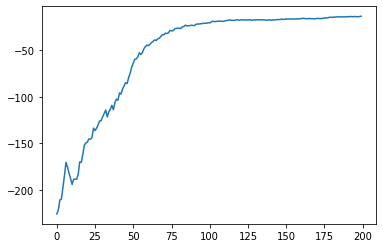

In [45]:
plt.plot(fits.mean(dim=-1))

In [46]:
fits.max()

tensor(-11.6057)